In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

### personal library

In [2]:
class Jackknife:
    def __init__( self, len_data, binsize ):
        self.binsize = binsize
        self.nbins = int(len_data/self.binsize)
        self.N = self.binsize * self.nbins
        self.jack_avg = []
        self.est = 0
        self.var_est = 0

    def set( self, func, list_of_data ):
        for i in range( self.nbins ):
            self.jack_avg.append( func( i, self.binsize, list_of_data ) )

    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)

def simple_mean(i, binsize, np_data):
    resmpld = np.delete(np_data, np.s_[i*binsize:(i+1)*binsize])
    return np.mean(resmpld)

def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+' exact:'+'{ex:.{width}f}'.format(ex=exact, width=i+2)+' ['+'{num:.{width}f}'.format(num=abs(exact-cen)/err, width=2)+' sigma]'

### related to Fourier coefficients

In [3]:
def Hankel_nu_k(nu,k):
    return sc.gamma(nu+k+0.5)/(sc.gamma(k+1)*sc.gamma(nu-k+0.5))

In [4]:
def A_nu_k(nu,k):
    return sc.polygamma(0,nu+k+0.5)-sc.polygamma(0,nu-k+0.5)

In [5]:
def B_nu_k(nu,k):
    return sc.polygamma(1,nu+k+0.5)-sc.polygamma(1,nu-k+0.5)

In [6]:
def lambdae_asymp(nu,z,kmax=4): # scaled with exp
    s=0.0
    for k in np.arange(kmax):
        s+=Hankel_nu_k(nu,k)*(-0.5/z)**k
    
    return s/np.sqrt(2.0*np.pi*z)

In [7]:
def d_dnu_ive_numeric(nu,z,eps=0.00001):
    return (sc.ive(nu+eps,z)-sc.ive(nu-eps,z))/(2.0*eps)

In [8]:
def d_dnu_lambdae_asymp(nu,z,kmax=4): # scaled with exp
    s=0.0
    for k in np.arange(kmax):
        s+=Hankel_nu_k(nu,k)*A_nu_k(nu,k)*(-0.5/z)**k

    return s/np.sqrt(2.0*np.pi*z)

In [9]:
def d2_dnu2_ive_numeric(nu,z,eps=0.0001):
    return (sc.ive(nu+eps,z)+sc.ive(nu-eps,z)-2.0*sc.ive(nu,z))/eps**2

In [10]:
def d2_dnu2_lambdae_asymp(nu,z,kmax=4): # scaled with exp
    s=0.0
    for k in np.arange(kmax):
        s+=Hankel_nu_k(nu,k)*(A_nu_k(nu,k)**2+B_nu_k(nu,k))*(-0.5/z)**k
 
    return s/np.sqrt(2.0*np.pi*z)

### exact solutions

In [11]:
def Z(beta_,theta_,vlat_,nmax_=3):
    res = 0.0

#     for n in range(-nmax_,nmax_+1):
#         res += sc.iv(n,beta_)**vlat_
    for n in range(-nmax_,nmax_+1):
        res += (np.exp(beta_)*lambdae_asymp(n-theta_/(2.0*np.pi),beta_))**vlat_

    return res

In [12]:
def avg_plaq(beta_,vlat_,nmax_=3):
    denom=0.0
    numer=0.0

    for n in range(-nmax_,nmax_+1):
        denom += sc.ive(n,beta_)**vlat_
        numer += (sc.ive(n+1,beta_)+sc.ive(n-1,beta_))*sc.ive(n,beta_)**(vlat_-1)

    return 0.5*numer/denom

In [13]:
def avg_plaq_sq(beta_,vlat_,nmax_=3):
    denom=0.0
    numer=0.0

    for n in range(-nmax_,nmax_+1):
        denom += sc.ive(n,beta_)**vlat_
        numer += (sc.ive(n+2,beta_)+2.0*sc.ive(n,beta_)+sc.ive(n-2,beta_))*sc.ive(n,beta_)**(vlat_-1)

    return 0.25*numer/denom

In [14]:
def avg_plaq_twopt(beta_,vlat_,nmax_=3):
    denom=0.0
    numer=0.0

    for n in range(-nmax_,nmax_+1):
        denom += sc.ive(n,beta_)**vlat_
        numer += (sc.ive(n+1,beta_)+sc.ive(n-1,beta_))**2 * sc.ive(n,beta_)**(vlat_-2)

    return 0.25*numer/denom

In [15]:
# def Q(beta_,vlat_,nmax_=3):
#     denom=0.0
#     numer=0.0

#     for n in range(-nmax_,nmax_+1):
#         denom += sc.ive(n,beta_)**vlat_
#         numer += d_dnu_lambda_asymp(n,beta_)*sc.ive(n,beta_)**(vlat_-1)

#     return vlat*numer/denom

In [16]:
def Qsq(beta_,vlat_,nmax_=3):
    denom=0.0
    numer=0.0

    for n in range(-nmax_,nmax_+1):
        denom += sc.ive(n,beta_)**vlat_
        numer += d2_dnu2_lambdae_asymp(n,beta_)*sc.ive(n,beta_)**(vlat_-1)

    numer *= vlat_
    
    return -numer/denom/(2.0*np.pi)**2

### acceptance

In [17]:
acc=np.loadtxt("./results/accept_reject.dat")
np.mean(acc)

0.839

In [18]:
dh=np.loadtxt("./results/dH.dat")

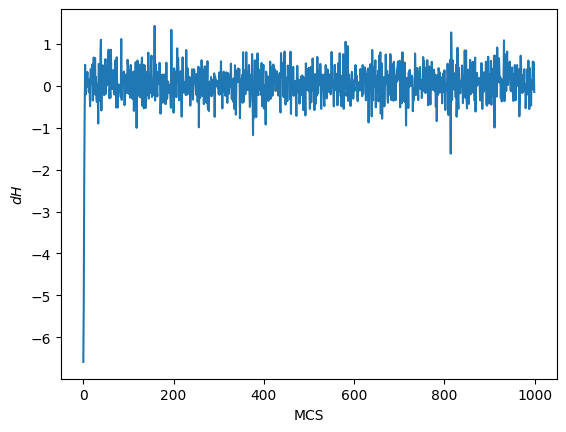

In [19]:
plt.plot(dh)
plt.xlabel("MCS")
plt.ylabel("$dH$")
plt.show()

# numerical parameters

In [20]:
a=1.0/1.8
beta=1/a**2
print("beta="+str(beta))
lx=16
ly=16
vlat=lx*ly

beta=3.2399999999999998


In [21]:
nskip=200
nconf=800

### average plaquette

In [22]:
w0_=[]

for n in range(nskip,nconf):
    dat=np.loadtxt("./results/w0/"+str(n)+".dat")
    w0_.append(dat)
    
w0=np.array(w0_)

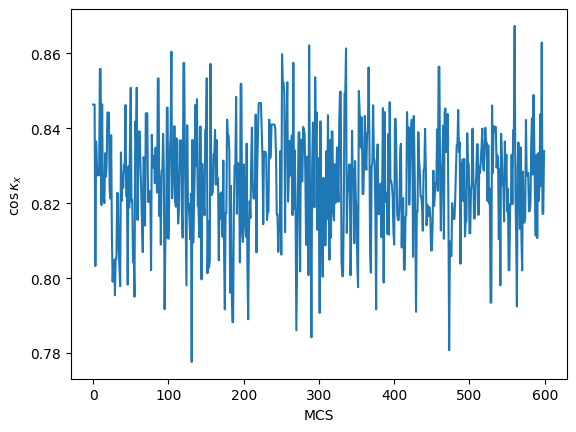

In [23]:
plt.plot(w0)
plt.xlabel("MCS")
plt.ylabel("$\\cos \\kappa_x$")
plt.show()

In [24]:
binsize=4

In [25]:
jk = Jackknife(nconf-nskip, binsize)
jk.set(simple_mean, w0)
jk.do_it()
mu_w0=jk.mean()
sig_w0=jk.err()
print(format_print_w_exact(avg_plaq(beta,vlat), mu_w0, sig_w0))

0.82582(73) exact:0.826274 [0.63 sigma]


### correlator

In [26]:
corr_=[]

for n in range(nskip,nconf):
    dat=np.loadtxt("./results/corr/"+str(n)+".dat")
    corr_.append(dat)
    
corr=np.array(corr_)

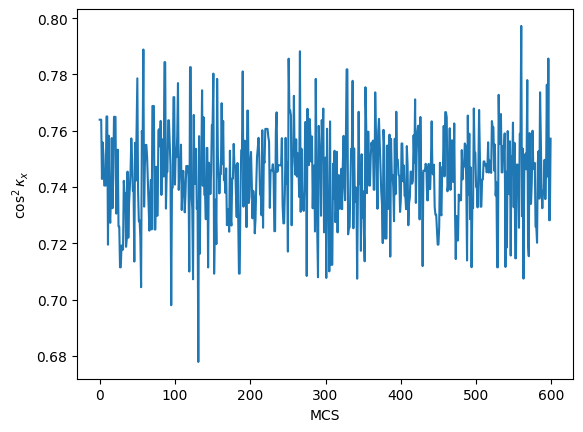

In [27]:
plt.plot(corr.T[0])
plt.xlabel("MCS")
plt.ylabel("$\\cos^2 \\kappa_x$")
plt.show()

In [28]:
binsize=4

In [29]:
for dx in range(int(lx/2)):
    jk = Jackknife(nconf-nskip, binsize)
    jk.set(simple_mean, corr.T[dx])
    jk.do_it()
    mu=jk.mean()
    sig=jk.err()
    if dx==0:
        print("dx="+str(dx)+": "+format_print_w_exact(avg_plaq_sq(beta,vlat),mu, sig))
    else:
        print("dx="+str(dx)+": "+format_print_w_exact(avg_plaq_twopt(beta,vlat),mu, sig))

dx=0: 0.74427(73) exact:0.744977 [0.96 sigma]
dx=1: 0.6818(12) exact:0.68273 [0.71 sigma]
dx=2: 0.6817(12) exact:0.68273 [0.86 sigma]
dx=3: 0.6818(12) exact:0.68273 [0.73 sigma]
dx=4: 0.6821(12) exact:0.68273 [0.55 sigma]
dx=5: 0.6818(12) exact:0.68273 [0.73 sigma]
dx=6: 0.6815(12) exact:0.68273 [0.97 sigma]
dx=7: 0.6817(12) exact:0.68273 [0.87 sigma]


### topological charge

In [30]:
Ql_=[]

for n in range(nskip,nconf):
    dat=np.loadtxt("./results/top_ch/"+str(n)+".dat")
    Ql_.append(dat)
    
Ql=np.array(Ql_)

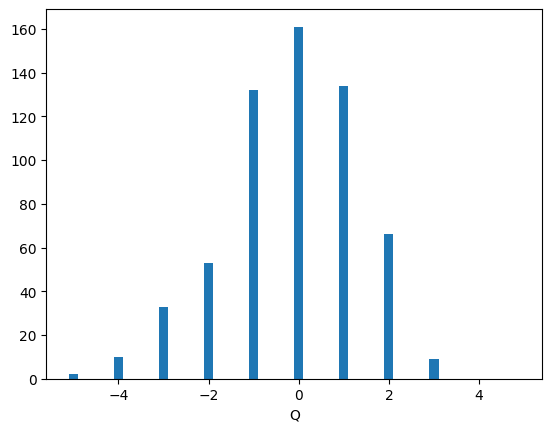

In [31]:
plt.hist(Ql,bins=np.arange(-5.1,5,0.2))
plt.xlabel("Q")
plt.show()

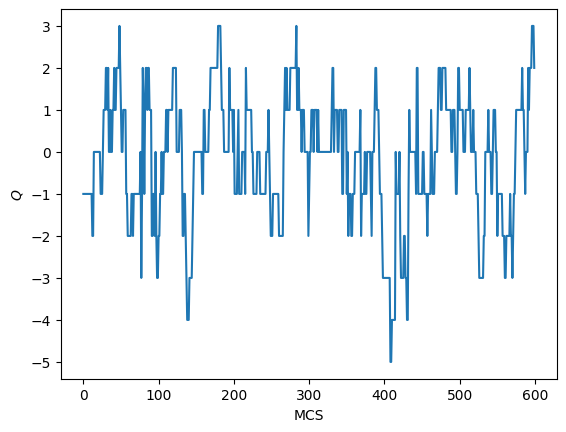

In [32]:
plt.plot(Ql)
plt.xlabel("MCS")
plt.ylabel("$Q$")
plt.show()

In [33]:
binsize=40

In [34]:
jk = Jackknife(nconf-nskip, binsize)
jk.set(simple_mean, Ql)
jk.do_it()
Qmu=jk.mean()
Qsig=jk.err()
print(format_print_w_exact(0.0, Qmu, Qsig))

-0.16(20) exact:0.000 [0.77 sigma]


### $Q^2$

In [35]:
Qlsq=Ql**2

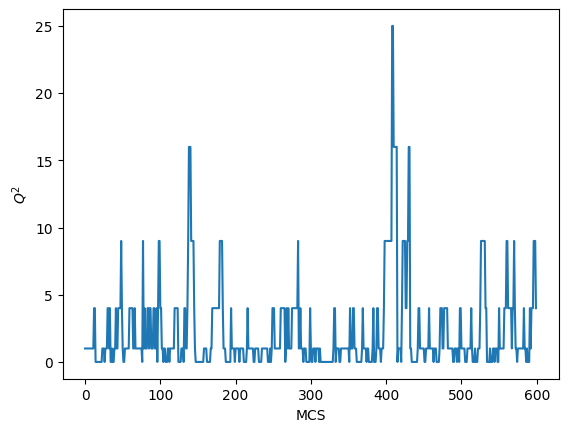

In [36]:
plt.plot(Qlsq)
plt.xlabel("MCS")
plt.ylabel("$Q^2$")
plt.show()

In [37]:
binsize=20

In [38]:
jk = Jackknife(nconf-nskip, binsize)
jk.set(simple_mean, Qlsq)
jk.do_it()
Qmu=jk.mean()
Qsig=jk.err()
print(format_print_w_exact(Qsq(beta,vlat), Qmu, Qsig))

2.22(34) exact:2.397 [0.52 sigma]
